In [30]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [31]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

In [32]:
!wget $data 

--2025-10-08 22:16:45--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv.2’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.008s  

2025-10-08 22:16:45 (104 MB/s) - ‘car_fuel_efficiency.csv.2’ saved [874188/874188]



In [33]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [34]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [35]:
df.columns

Index(['engine_displacement', 'num_cylinders', 'horsepower', 'vehicle_weight',
       'acceleration', 'model_year', 'origin', 'fuel_type', 'drivetrain',
       'num_doors', 'fuel_efficiency_mpg'],
      dtype='object')

In [36]:
selected_columns_df = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]

In [37]:
selected_columns_df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

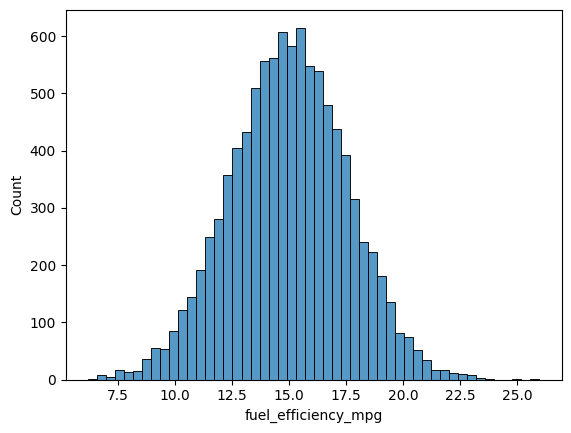

In [38]:
sns.histplot(selected_columns_df.fuel_efficiency_mpg, bins=50)

In [39]:
# Question 1: There's one column with missing values. What is it?
selected_columns_df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [40]:
#Q2. Median value of horsepower
median = selected_columns_df['horsepower'].median()
median

np.float64(149.0)

In [41]:
#Setting up the validation framework:::Train, Val, Test
n = len(selected_columns_df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)

In [42]:
n_val, n_test, n_train

(1940, 1940, 5824)

In [43]:
idx = np.arange(n)

In [44]:
idx

array([   0,    1,    2, ..., 9701, 9702, 9703], shape=(9704,))

In [45]:
#Deterministic random ordering
np.random.seed(42)
np.random.shuffle(idx)

In [46]:
#data frame with shuffled indexes
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

In [47]:
#reset the index - we do not need to know the original index value
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [48]:
y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

In [49]:
y_train

array([2.8703359 , 2.85061269, 2.97511223, ..., 2.92279789, 2.99201277,
       2.94261017], shape=(5824,))

In [50]:
#Delete the original values to prevent them from accidentally using it (price variable will be accidentally used as feature price)
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [57]:
# Question 3
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [58]:
# option1: fillna it with 0
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']

X_train_0 = df_train[base].fillna(0).values

w0, w = train_linear_regression(X_train_0, y_train)

y_pred = w0 + X_train_0.dot(w)

In [59]:
y_pred

array([2.90981589, 2.84278709, 2.93310627, ..., 2.92329662, 3.00305539,
       2.94404905], shape=(5824,))

<Axes: ylabel='Count'>

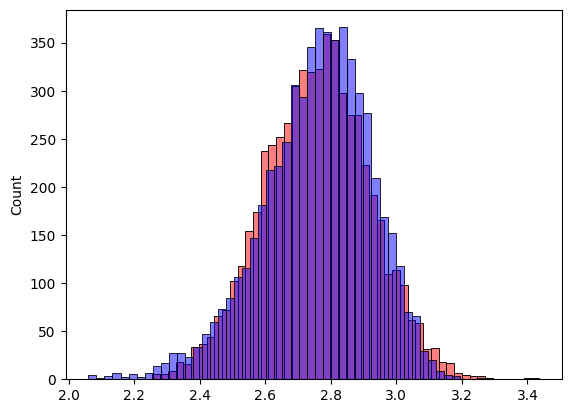

In [60]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [61]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [62]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [65]:
# RMSE with 0
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse_0 = rmse(y_val, y_pred).round(2)
rmse_0

np.float64(0.04)

In [ ]:
# option2: fillna it with mean
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']

X_train_0 = df_train[base].fillna(0).values

w0, w = train_linear_regression(X_train_0, y_train)

y_pred = w0 + X_train_0.dot(w)

In [66]:
mean = df_train[base]['horsepower'].mean()

In [67]:
mean

np.float64(149.54476367006487)

In [68]:
X_train_mean = df_train[base].fillna(mean).values

In [69]:
w0, w = train_linear_regression(X_train_mean, y_train)

y_pred = w0 + X_train_mean.dot(w)

In [70]:
y_pred

array([2.90493466, 2.83614915, 2.93281288, ..., 2.92153243, 3.00286793,
       2.94287685], shape=(5824,))

<Axes: ylabel='Count'>

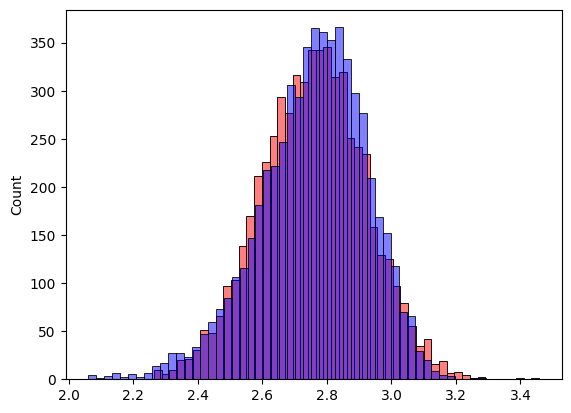

In [71]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [72]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(mean)
    X = df_num.values
    return X

In [73]:
# RMSE with mean
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse_mean = rmse(y_val, y_pred).round(2)
rmse_mean

np.float64(0.04)

In [75]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [74]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [ ]:
#Question 4 - If multiple options give the same best RMSE, select the smallest r



In [77]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred).round(2)
    
    print(r, w0, score)

0 3.6646662472218297 0.04
0.01 3.1688134470074534 0.04
0.1 1.4288369989383432 0.04
1 0.22012861946726972 0.04
5 0.04624885656570121 0.04
10 0.023271722731248758 0.04
100 0.0023413689852701753 0.04
